# Prédiction des données de vente d'un restaurant

Ce document retrace le processus d'étude des données de vente et la construction d'un modèle de prédiction des vente d'un restaurant.


In [7]:
# import des librairies

# On importe les données de pré-traitement
import os
import sys
sys.path.append( os.path.dirname( os.path.dirname( os.path.abspath('dionysos') ) ) )


# Manipulation de donnée
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pour gérer les dates et le temps
from datetime import datetime
import time
import locale
# Définir la langue française
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# Scrapping
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# log
import logging as lg
lg.basicConfig(level=lg.INFO)


## Pré-traitement des données

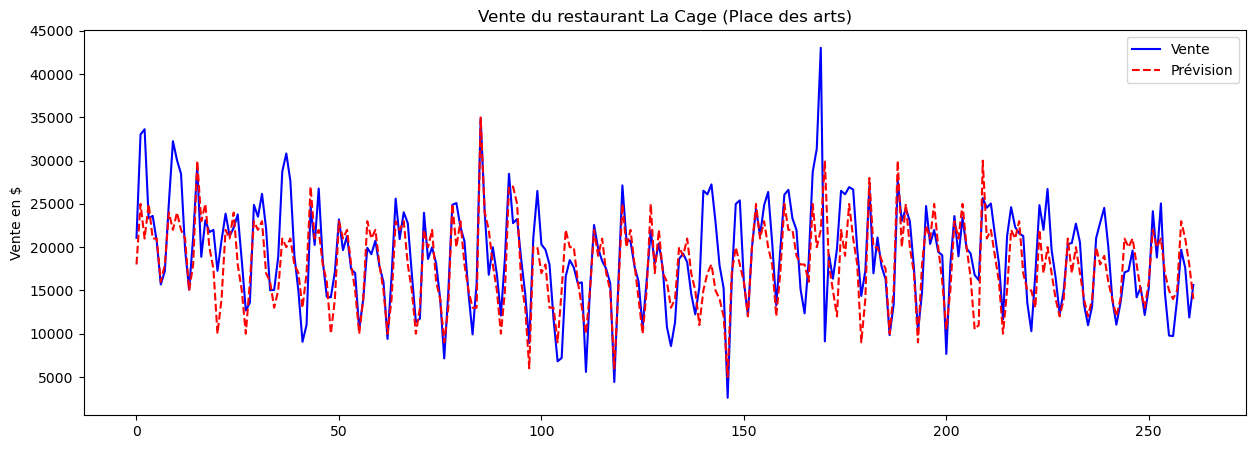

In [13]:
# Chemin absolu du fichier CSV dans le document parent
chemin_fichier_csv = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('dionysos'))),'data', 'data_vente.csv')

# import des données avec comme séparateur ';'
df = pd.read_csv(chemin_fichier_csv, sep=';')

# On enlève les données avec des ventes nulles (restaurant fermé) inutile aux prévisions
df = df[df['vente'] != 0]

# convertie df['Vente'] en float
vente = list(df['vente'].astype(float))
prevision = list(df['prevision'].astype(float))
date = list(df['date']) 

# on affiche les données
plt.figure(figsize=(15, 5))
plt.plot(vente, color='blue', linestyle='-', label='Vente')
plt.plot(prevision, color='red', linestyle='--', label='Prévision')
plt.ylabel("Vente en $")
plt.title('Vente du restaurant La Cage (Place des arts)')
plt.legend()
plt.show()


### Complément de données

En regardant les données, on voit que celles-ci fluctuent énormement. Ces données correspondent aux ventes d'un restaurant par jour dans la periode de semptembre 2022 jusqu'à avril 2023. Ainsi, suivant le jour de la semaine et la saison, les ventes sont plus ou moins élévé. Par exemple, il est plus cohérent d'avoir plus de vente un vendredi qu'un lundi. De même, on observera plus de vente en été qu'en hiver. 

On décide alors de rajouter : 
* Le jour de la semaine correspondant 
* La saison 
* Si ces un jour férié ou non

Cela afin de nous permettre de mieux lire les données receuillis.


In [3]:
'''
Jour de la semaine
'''

# On ajoute une colonne 'Jour' qui contient le jour de la semaine
def date2day(date_str):
    '''
    Cette fonction permet de convertire une date en jour de la semaine
    correspondant
        * Input :  (Str) Date '%d-%m-%Y'
        * Output : (Str) Jour de la semaine
    '''
    # Conversion de la chaîne de caractères en objet de type 'datetime'
    date_obj = datetime.strptime(date_str, '%d-%m-%Y')
    # Obtention du jour de la semaine (0 = lundi, 1 = mardi, ..., 6 = dimanche)
    jour_semaine = date_obj.weekday()
    # Liste des jours de la semaine
    jours = ['lundi', 'mardi', 'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche']
    # Affichage du jour correspondant à la date donnée
    jour_correspondant = jours[jour_semaine]
    return jour_correspondant

df['day'] = df['date'].apply(date2day)

'''
Saison
'''

# On ajoute une colonne 'Saison' qui contient la saison
def date2saison(date_str):
    '''
    Cette fonction permet de convertire une date en saison correspondante
        * Input :  (Str) Date '%d-%m-%Y'
        * Output : (Str) Saison
    '''
    # Conversion de la chaîne de caractères en objet de type 'datetime'
    date_obj = datetime.strptime(date_str, '%d-%m-%Y')
    # Obtention du mois
    mois = date_obj.month
    # Liste des saisons
    saisons = ['hiver', 'printemps', 'été', 'automne']
    # Affichage de la saison correspondant à la date donnée
    saison_correspondante = saisons[(mois%12)//3]
    return saison_correspondante

df['saison'] = df['date'].apply(date2saison)

'''
Jour ferié
'''

# On ajoute une colonne 'JourFerie' qui contient si c'est un jour férié ou non
def date2jourferie(date_str):
    '''
    Cette fonction permet de convertire une date en jour férié correspondant
        * Input :  (Str) Date '%d-%m-%Y'
        * Output : (Str) Jour férié
    '''
    # Liste des jours fériés au canada
    jours_feries = [
    '2022-09-05',  # Fête du travail (Labour Day)
    '2022-10-10',  # Action de grâce (Thanksgiving)
    '2022-12-25',  # Noël (Christmas)
    '2022-12-26',  # Lendemain de Noël (Boxing Day)
    '2023-01-01',  # Jour de l'An (New Year's Day)
    '2023-02-20',  # Fête de la famille (Family Day)
    '2023-04-14',  # Vendredi saint (Good Friday)
    '2023-05-22',  # Fête de la Reine (Victoria Day)
    '2023-07-01',  # Fête du Canada (Canada Day)
    '2023-09-04',  # Fête du travail (Labour Day)
    '2023-10-09',  # Action de grâce (Thanksgiving)
    '2023-12-25',  # Noël (Christmas)
    '2023-12-26'   # Lendemain de Noël (Boxing Day) 
    ]
    # Affichage de la saison correspondant à la date donnée
    if date_str in jours_feries:
        return 'oui'
    else:
        return 'non'
    
df['jour_ferie'] = df['date'].apply(date2jourferie)

'''
Vacance
'''

# On ajoute une colonne 'Vacances' qui contient si c'est les vacances ou non
def date2vacances(date_str):
    '''
    Cette fonction permet de vérifier si une date se trouve pendant les vacances au Canada.
        * Input :  (str) Date au format '%d-%m-%Y'
        * Output : (str) 'oui' si c'est pendant les vacances, 'non' sinon
    '''
    # Liste des périodes de vacances au Canada
    vacances = [
        ('2022-12-17', '2023-01-02'),  # Vacances d'hiver
        ('2023-03-04', '2023-03-19'),  # Vacances de mars
        ('2023-06-24', '2023-08-27')   # Vacances d'été
    ]

    # Conversion de la date en objet datetime
    date = datetime.strptime(date_str, '%d-%m-%Y').date()

    # Vérification si la date se trouve pendant les vacances
    for debut, fin in vacances:
        debut_vacances = datetime.strptime(debut, '%Y-%m-%d').date()
        fin_vacances = datetime.strptime(fin, '%Y-%m-%d').date()
        if debut_vacances <= date <= fin_vacances:
            return 1

    return 0

df['vacances'] = df['date'].apply(date2vacances)


# On affiche les 5 premières lignes du dataframe
df.head()


,date,prevision,vente,day,saison,jour_ferie,vacances
0,21-05-2023,18000,21084.84,dimanche,printemps,non,0
1,20-05-2023,25000,33030.85,samedi,printemps,non,0
2,19-05-2023,21000,33632.64,vendredi,printemps,non,0
3,18-05-2023,25000,23333.76,jeudi,printemps,non,0
4,17-05-2023,21000,23617.35,mercredi,printemps,non,0


On peut alors afficher les ventes par jour de la semaine et par saison.

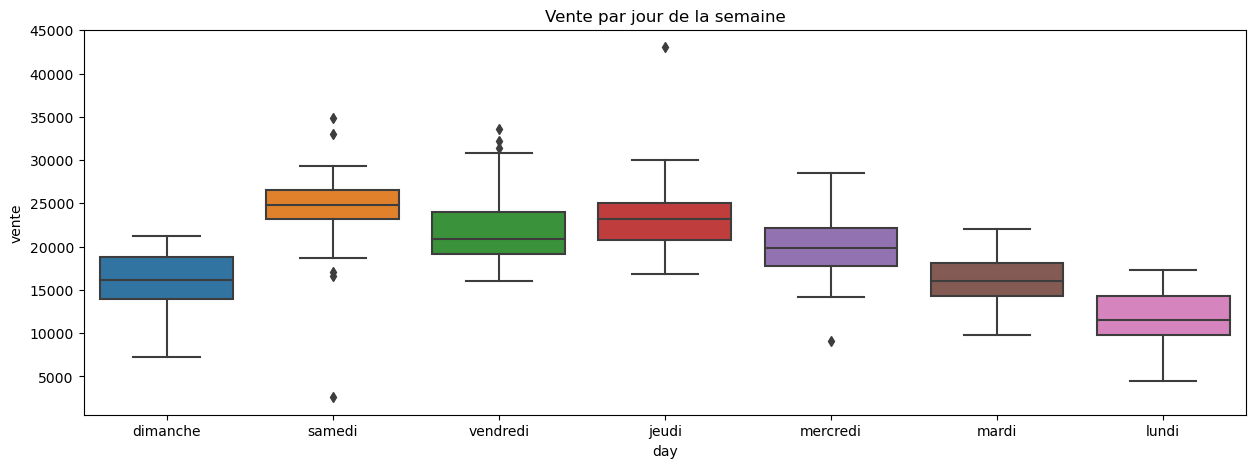

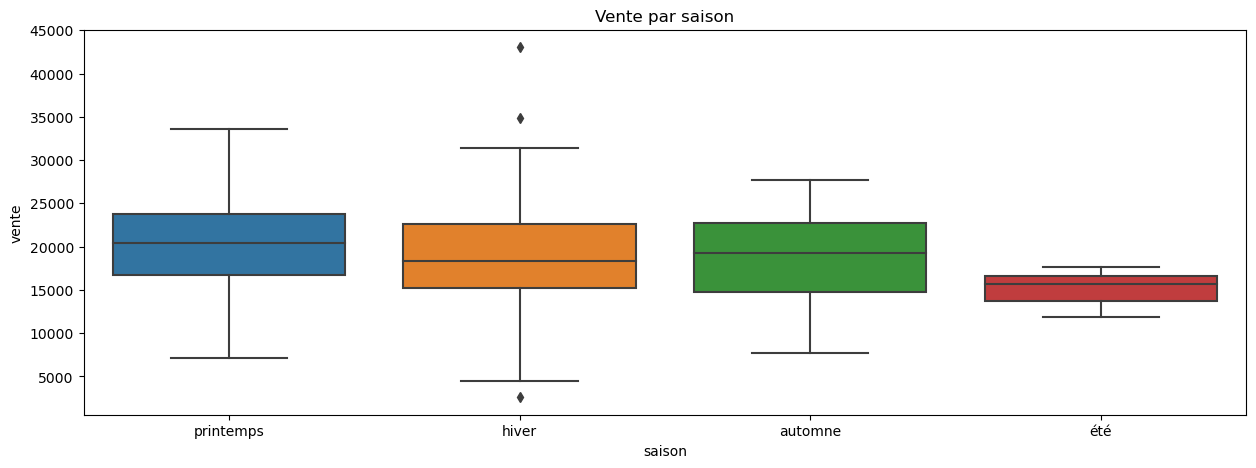

In [4]:
#On peut alors afficher les ventes par jour de la semaine et par saison.

# On affiche les ventes par jour de la semaine
plt.figure(figsize=(15, 5))
sns.boxplot(x='day', y='vente', data=df)
plt.title('Vente par jour de la semaine')
plt.show()

# On affiche les ventes par saison
plt.figure(figsize=(15, 5))
sns.boxplot(x='saison', y='vente', data=df)
plt.title('Vente par saison')
plt.show()



### Étude du modèle de prédiction actuelle

In [5]:
erreur = np.abs(np.multiply(np.divide(np.subtract(vente, prevision),vente),100))
print("L'erreur moyenne des prévisions actuelles est {} % avec un maximum de {} % d'erreur observé le {}".format(round(np.mean(erreur),1), round(np.max(erreur),1), date[np.argmax(erreur)]))

L'erreur moyenne des prévisions actuelles est 16.3 % avec un maximum de 229.2 % d'erreur observé le 30-11-2022


In [8]:
# Exemple de date
date_text = "Mer, 24 Mai 2023"

# Convertir la date en objet datetime en utilisant le format spécifique
date_object = datetime.strptime(date_text, "%a, %d %b %Y")

# Extraire le jour, le mois et l'année de l'objet datetime
jour = date_object.day
mois = date_object.month
annee = date_object.year

# Afficher le jour, le mois et l'année
print("Jour :", jour)
print("Mois :", mois)
print("Année :", annee)

Jour : 24
Mois : 5
Année : 2023


## Scrapping des emplois du temps

On chercher à recuperer les données sur le planning des aides-serveurs sur planifico

In [ ]:
import data.scrapping_planifico as sp

# On récupère les données de planifico
df_planifico = sp.get_data()